In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats
import os
from scripts.seed_corr import import_ts, correlate_ts, get_conn, get_data, select_regions
import seaborn as sb

base_dir = '/Users/callithrix/Documents/Projects/Degeneration/derivatives/'
code_dir = '/Users/callithrix/Documents/Projects/Degeneration/code/cerebellar_degeneration'


In [3]:
ts, rois, subjects, sessions = import_ts()
coefs = correlate_ts(ts)
conn = get_conn(coefs, rois)

d = pd.read_csv(code_dir + '/data/connectivity.tsv', sep='\t')
len(d.subject.unique())

/Users/callithrix/Documents/Projects/Degeneration/code/cerebellar_degeneration/util.py:7: RuntimeWarning: invalid value encountered in divide
  X = X / np.sqrt(np.nansum(X**2, axis=0)/X.shape[0])


79

In [4]:

d = pd.read_csv(code_dir + '/data/connectivity.tsv', sep='\t')
D = pd.read_csv(code_dir + '/data/connectivity_wide.tsv', sep='\t')
len(d.subject.unique())

79

In [5]:
# Set patient and control colours from rgb codes
patient_col = '#BB271A'
control_col = '#153969'
custom_palette = [control_col, patient_col]
sb.set_context('talk')
ylim = (0.12, 0.58)


## Outlier analysis

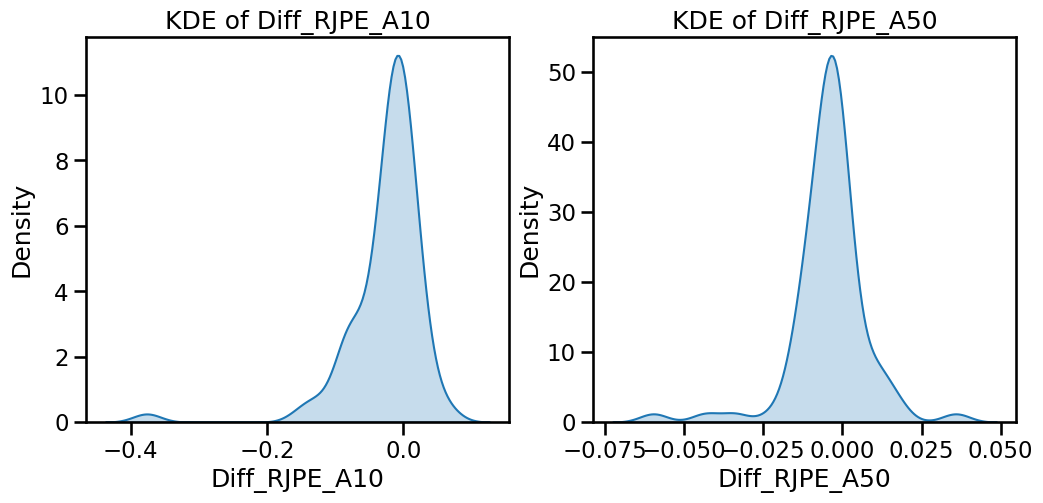

In [6]:

plt.figure(figsize=(12, 5))

# KDE Plot (Smoothed distribution)
plt.subplot(1, 2, 1)
sb.kdeplot(D['Diff_RJPE_A10'], fill=True)
plt.title('KDE of Diff_RJPE_A10')

plt.subplot(1, 2, 2)
sb.kdeplot(D['Diff_RJPE_A50'], fill=True)
plt.title('KDE of Diff_RJPE_A50')

plt.show()


In [7]:

def grubbs_test(data, alpha=0.05):
    """Applies Grubbs' test iteratively to detect outliers."""
    outlier_values = []
    outlier_indices = []
    new_data = data.copy()

    while True:
        n = len(new_data)
        if n < 3:  # Grubbs' test requires at least 3 points
            break

        # Compute Grubbs' test statistic
        mean_y = np.mean(new_data)
        std_y = np.std(new_data, ddof=1)  # Sample standard deviation
        G = np.max(np.abs(new_data - mean_y) / std_y)

        # Compute critical value
        t_crit = stats.t.ppf(1 - alpha / (2 * n), df=n - 2)  # Two-tailed test
        G_crit = ((n - 1) / np.sqrt(n)) * np.sqrt(t_crit ** 2 / (n - 2 + t_crit ** 2))

        # Check if the maximum outlier is significant
        if G > G_crit:
            outlier_idx = np.argmax(np.abs(new_data - mean_y))
            outlier_values.append(new_data[outlier_idx])
            outlier_indices.append(outlier_idx)
            new_data = np.delete(new_data, outlier_idx)  # Remove outlier

        else:
            break

    return outlier_values, outlier_indices


In [ ]:
Data_diff = D[D.session == 'ses-post']

# Apply Grubbs' test to detect outliers
outliers_A10, indices_A10 = grubbs_test(Data_diff['Diff_RJPE_A10'].dropna().values)
outliers_A50, indices_A50 = grubbs_test(Data_diff['Diff_RJPE_A50'].dropna().values)

outlier_subjects_A10 = Data_diff.iloc[indices_A10].subject
outlier_subjects_A50 = Data_diff.iloc[indices_A50].subject

print("Grubbs' Test Outliers in Diff_RJPE_A10:", outliers_A10)
print("Grubbs' Test Outliers in Diff_RJPE_A50:", outliers_A50)


Grubbs' Test Outliers in Diff_RJPE_A10: [-0.3760868]
Grubbs' Test Outliers in Diff_RJPE_A50: [-0.059579564, -0.04316527, 0.03583169, -0.033889003]


In [9]:
# D[D.subject.isin(outlier_subjects_A10) | D.subject.isin(outlier_subjects_A50)]
D_no_outliers = D[~D.subject.isin(outlier_subjects_A10) & ~D.subject.isin(outlier_subjects_A50)]
d_no_outliers = d[d.subject.isin(D_no_outliers.subject)]
d_no_outliers.to_csv(code_dir + '/data/connectivity_no_outliers.tsv', sep='\t')

D[D.subject.isin(outlier_subjects_A10) | D.subject.isin(outlier_subjects_A50)][['subject', 'session', 'group', 'condition', 'Diff_RJPE_A10', 'Diff_RJPE_A50']]

,subject,session,group,condition,Diff_RJPE_A10,Diff_RJPE_A50
0,sub-01,ses-post,p,PropFB,-0.009905,0.035832
1,sub-01,ses-pre,p,PropFB,-0.009905,0.035832
14,sub-08,ses-post,p,VM,-0.376087,0.010072
15,sub-08,ses-pre,p,VM,-0.376087,0.010072
56,sub-29,ses-post,p,Prop,-0.131542,-0.043165
57,sub-29,ses-pre,p,Prop,-0.131542,-0.043165
58,sub-30,ses-post,p,VMFB,-0.120752,-0.059580
59,sub-30,ses-pre,p,VMFB,-0.120752,-0.059580
102,sub-52,ses-post,c,VM,-0.064169,-0.012443
103,sub-52,ses-pre,c,VM,-0.064169,-0.012443
